# 1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

## 1. Get data

In [ ]:
# Get data (10% of 10 food classes from Food10)
import zipfile

# Download the file
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-11-21 04:44:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2022-11-21 04:44:57 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder
import os

# Walk through 10 percent data directory ad list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## 2. Create data loaders

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE =32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## 3. Create TensorBoard callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each mode)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback



## 4. Create model function

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and create a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
    should be equal to number of targer classes, default 10

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor 
    layer and Dense output layer with num_classes output neurons.

  """
  # Download the pretrained model and save it as Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned patterns



  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer" )

  ])

  return model


* model url

In [ ]:
mobilenetv2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

## 5. Create model

In [ ]:
# Create Resnet model
mobilenetv2_model = create_model(mobilenetv2_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


## 6. Compile model

In [ ]:
mobilenetv2_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


## 7. Fit model

In [ ]:
# Fit model
mobilenetv2_history = mobilenetv2_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="mobilenetv2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20221121-040736
Epoch 1/5
24/24 [==============================] - 70s 3s/step - loss: 2.0269 - accuracy: 0.3013 - val_loss: 1.3720 - val_accuracy: 0.5840
Epoch 2/5
24/24 [==============================] - 97s 4s/step - loss: 1.0613 - accuracy: 0.6973 - val_loss: 0.9319 - val_accuracy: 0.7160
Epoch 3/5
24/24 [==============================] - 67s 3s/step - loss: 0.7451 - accuracy: 0.7933 - val_loss: 0.7585 - val_accuracy: 0.7740
Epoch 4/5
24/24 [==============================] - 67s 3s/step - loss: 0.5869 - accuracy: 0.8387 - val_loss: 0.6872 - val_accuracy: 0.7900
Epoch 5/5
24/24 [==============================] - 67s 3s/step - loss: 0.4775 - accuracy: 0.8907 - val_loss: 0.6595 - val_accuracy: 0.7900


* Resnet

Epoch 5/5
24/24 [==============================] - 20s 856ms/step - loss: 0.3343 - accuracy: 0.9280 - val_loss: 0.6478 - val_accuracy: 0.7880

* efficientnet

Epoch 5/5
24/24 [==============================] - 16s 667ms/step - loss: 0.5150 - accuracy: 0.8867 - val_loss: 0.5558 - val_accuracy: 0.8644

*MOBILENETV2
Epoch 5/5
24/24 [==============================] - 67s 3s/step - loss: 0.4775 - accuracy: 0.8907 - val_loss: 0.6595 - val_accuracy: 0.7900

# 2. Name 3 different image classification models on TensorFlow Hub that we haven't used.

* Inception ResNet
* Inception family of models
* NASNet models
* Some of the ResNet versions of models

https://tfhub.dev/s?module-type=image-classification&tf-version=tf2

# 3. Build a model to classify images of two different things you've taken photos of.

## 1. Import gdrive

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Get data path

In [ ]:
import os

# Getting the data dir path
data_dir = '/content/drive/MyDrive/data/images'

for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/data/images'.
There are 0 directories and 5 images in '/content/drive/MyDrive/data/images/cat'.
There are 0 directories and 5 images in '/content/drive/MyDrive/data/images/hamster'.


Use the image dataset from directory to read in the data

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir , 
                                                                 labels = 'inferred', 
                                                                 image_size = IMAGE_SHAPE , 
                                                                 batch_size = 8)

Found 10 files belonging to 2 classes.


Visualize data

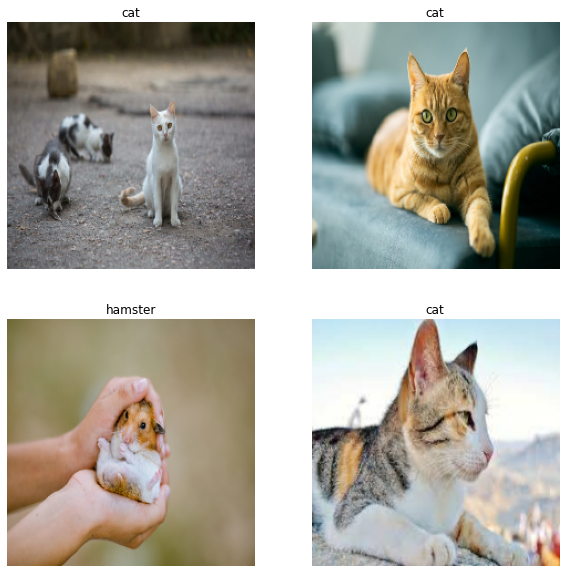

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
class_names = train_data.class_names
for images, labels in train_data.take(1):
  for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis(False);

use the above mobilenet feature extractor model to train on our custom data.

In [ ]:
feature_extractor_layer = hub.KerasLayer(mobilenetv2_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned patterns


## 3. Create model

In [ ]:
custom_model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(1, activation='sigmoid', name='output_layer')
  ])

In [ ]:
custom_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


## 4. Compile model

In [ ]:
custom_model.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001) , 
                      metrics = ['accuracy'])

## 5. Fit model

In [ ]:
custom_model_history = custom_model.fit(train_data , 
                      epochs = 15 )

Epoch 1/15
2/2 [==============================] - 5s 82ms/step - loss: 0.6480 - accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 0s 93ms/step - loss: 0.5663 - accuracy: 0.8000
Epoch 3/15
2/2 [==============================] - 0s 80ms/step - loss: 0.5078 - accuracy: 0.8000
Epoch 4/15
2/2 [==============================] - 0s 83ms/step - loss: 0.4515 - accuracy: 1.0000
Epoch 5/15
2/2 [==============================] - 0s 81ms/step - loss: 0.4223 - accuracy: 1.0000
Epoch 6/15
2/2 [==============================] - 0s 94ms/step - loss: 0.4134 - accuracy: 0.9000
Epoch 7/15
2/2 [==============================] - 0s 80ms/step - loss: 0.3966 - accuracy: 0.9000
Epoch 8/15
2/2 [==============================] - 0s 79ms/step - loss: 0.3664 - accuracy: 0.9000
Epoch 9/15
2/2 [==============================] - 0s 85ms/step - loss: 0.3387 - accuracy: 0.9000
Epoch 10/15
2/2 [==============================] - 0s 101ms/step - loss: 0.2992 - accuracy: 1.0000
Epoch 11/15
2/2 [===========

Good accuracy!

## 6. Test model on random images

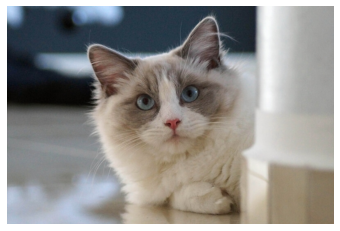

In [ ]:
import matplotlib.image as mpimg 
a = mpimg.imread('/content/drive/MyDrive/data/02_test_cat.jpg')
plt.imshow(a)
plt.axis(False);

In [ ]:
# Writing a function to import and image and resize it to be used with model predict
def load_and_prep_image(filename , img_shape = 224):
  # Read in the target image 
  img = tf.io.read_file(filename)

  # Decoding into a tensor 
  img = tf.image.decode_image(img , channels = 3)

  # Resize the image(same size as the model trained on)
  img = tf.image.resize(img , size = [img_shape , img_shape])

  # Rescale the image 
  img = img / 255.

  return img

In [ ]:
# Getting all the filepath and storing them into a variable 
cat_1 = '/content/drive/MyDrive/data/01_test_cat.jpg'
cat_2 = '/content/drive/MyDrive/data/02_test_cat.jpg'
hamster_1 = '/content/drive/MyDrive/data/03_test_hamster.jpg'
hamster_2 = '/content/drive/MyDrive/data/04_test_hamster.jpg'

In [ ]:
tf.expand_dims(load_and_prep_image(hamster_1), axis = 0).shape , images.shape

(TensorShape([1, 224, 224, 3]), TensorShape([8, 224, 224, 3]))

In [ ]:
dum = custom_model.predict(tf.expand_dims(load_and_prep_image(hamster_1), axis = 0))
dum

1/1 [==============================] - 0s 115ms/step


array([[0.7792046]], dtype=float32)

In [ ]:
class_names[int(tf.round(dum)[0][0])]

'hamster'

In [ ]:
# Creating a function to make prediction and display it

def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img , axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 235ms/step


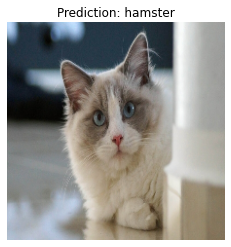

In [ ]:
# Getting our class names 
class_names = train_data.class_names

# Using the function to plot our prediction
pred_and_plot(custom_model , cat_2, class_names)

That is bad! the model couldn't detect cat

How to improve this?

* Increase the number of images per class to 20 -- increased to 10
 
* Create a validation set of images, where it will be having 5-8 images per class.
* Using another architecture, maybe EfficientNet for better performance.


## 1. Preprocess data (improvise)

In [ ]:
# Importing the needed packages 
import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# Getting the data path 
#data_dir = 'drive/MyDrive/data/images'
train_path = 'drive/MyDrive/data/complete/train'
test_path = 'drive/MyDrive/data/complete/test'

In [ ]:
# Let's get class names
data_dir = pathlib.Path(train_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['cat' 'hamster']


Data loaders

In [ ]:
import tensorflow as tf
# Using ImageDataGenerators to read in images with labels 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
# Creating a instance of the ImageDataGenerator 
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    validation_split = 0.3) # creating a valid split in the train data


# Grabbing our image file from directories 
train_data = train_datagen.flow_from_directory(data_dir , 
                                               batch_size = 2 , 
                                               target_size = (224 , 224), 
                                               class_mode = 'binary', 
                                               seed = 42 , 
                                               subset = 'training')

valid_data = train_datagen.flow_from_directory(data_dir , 
                                               batch_size = 2 , 
                                               target_size = (224, 224) , 
                                               class_mode = 'binary' , 
                                               seed = 42 , 
                                               subset = 'validation')

Found 14 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


* Visualize data

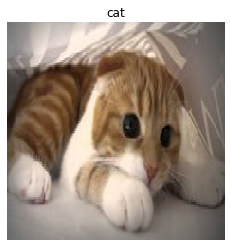

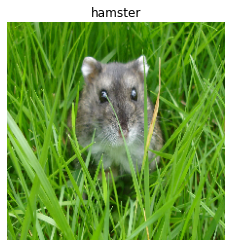

In [ ]:
# Let's do a simple visualization (checking purpose)
x , y  = train_data.next()
for i in range(2):
  image = x[i]
  label = y[i]
  plt.axis(False)
  # print(label) --> for checking whether it's plotting right ones
  if label == 1.0:
    label = 'hamster'
  else:
    label = 'cat'
  plt.title(label)
  plt.imshow(image)
  plt.show()

## 2. Model (improvise)

In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


efficientnet_feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # Freeze the already learned patterns


In [ ]:
# Create model
custom_model2 = tf.keras.Sequential([
      efficientnet_feature_extractor_layer,
      layers.Dense(1, activation='sigmoid', name='output_layer')
  ])

In [ ]:
# Compile model
custom_model2.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001) , 
                      metrics = ['accuracy'])

In [ ]:
# Fit model
custom_model_history2 = custom_model2.fit(train_data, 
                        epochs = 15,
                         validation_data=valid_data)

Epoch 1/15
7/7 [==============================] - 18s 1s/step - loss: 0.5482 - accuracy: 0.6429 - val_loss: 0.4766 - val_accuracy: 1.0000
Epoch 2/15
7/7 [==============================] - 2s 269ms/step - loss: 0.3764 - accuracy: 1.0000 - val_loss: 0.4110 - val_accuracy: 1.0000
Epoch 3/15
7/7 [==============================] - 2s 353ms/step - loss: 0.2562 - accuracy: 1.0000 - val_loss: 0.3697 - val_accuracy: 1.0000
Epoch 4/15
7/7 [==============================] - 2s 276ms/step - loss: 0.1843 - accuracy: 1.0000 - val_loss: 0.3383 - val_accuracy: 1.0000
Epoch 5/15
7/7 [==============================] - 2s 271ms/step - loss: 0.1399 - accuracy: 1.0000 - val_loss: 0.3132 - val_accuracy: 1.0000
Epoch 6/15
7/7 [==============================] - 2s 260ms/step - loss: 0.1060 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 1.0000
Epoch 7/15
7/7 [==============================] - 3s 435ms/step - loss: 0.0867 - accuracy: 1.0000 - val_loss: 0.2771 - val_accuracy: 1.0000
Epoch 8/15
7/7 [======

## Test using random images

1/1 [==============================] - 0s 157ms/step


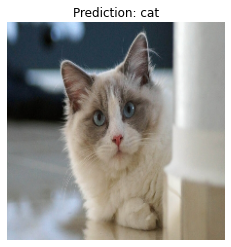

In [ ]:
# Getting our class names 
#class_names = data_dir.class_names

# Using the function to plot our prediction
pred_and_plot(custom_model2, cat_2, class_names)

Model performs better! It can detect both cats and hamster